## Surprise Housing Assignment

### Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.
The company wants to know:

- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

__Business Goal:__

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for the management to understand the pricing dynamics of a new market.

In [1]:
#Import the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
%matplotlib inline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

In [2]:
#Suppress Warnings
import warnings
warnings.filterwarnings('ignore') 

### Data Understanding and Exploration

Let's have a look at the dataset and understand the size, attribute names etc.

In [3]:
#Read the dataset
df = pd.read_csv('train.csv') 

In [4]:
#Summary
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
df.head() 

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

#### Understanding the Data Dictionary

The data dictionary contains the meaning of various variables; some non-obvious variables are:

In [6]:
df['MSSubClass'].value_counts() 

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

`MSSubClass`, is a categorical variable with numeric values.

In [7]:
df['OverallQual'].value_counts()  

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

`OverallQual` is an _ordinal variable_ which gives the overall quality of the house on the scale of 1 to 10, 1 being the lowest and 10 being the highest. The same is true for `OverallCond`.

In [8]:
df['BsmtCond'].value_counts() 

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

Here, `BsmtCond` has five different categories but it only shows four as the fifth category is defined a `NA`. Here, `NA` is not a missing value but it indicates that the house doesn't have a basement.

We have similar columns in the dataset that will be treated similarly.

In [9]:
df['Street'].value_counts() 

Pave    1454
Grvl       6
Name: Street, dtype: int64

`Street` is a highly biased variable and there are others like `Street` that will be treated in a similar fashion.

#### Data Exploration

Let's find out relationships between numeric variables. 

In [10]:
df_num_vars = df.select_dtypes(include=['float64', 'int64'])
df_num_vars.head() 

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  OpenPorchSF  \
0          2003       196.0         706  ...           0           61   
1          1976         0.0         978  ...         298            0   
2          2002       162.0         486  ...           0           42   
3          1970         0.0         216  ...           0           35   
4          2000       350.0         655  ...         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272          0            0         0        0       2    2006   
4              0          0            0         0        0      12    2008   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  
4     250000  

[5 rows x 38 columns]

Let's drop `Id` as it is irrelevent and drop the categorical variables with numeric values i.e. `MSSubClass`, `OverallQual`, and `OverallCond`.

In [11]:
df_num_vars = df_num_vars.drop(['Id', 'MSSubClass', 'OverallQual', 'OverallCond'], axis=1)
df_num_vars.head() 

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0         65.0     8450       2003          2003       196.0         706   
1         80.0     9600       1976          1976         0.0         978   
2         68.0    11250       2001          2002       162.0         486   
3         60.0     9550       1915          1970         0.0         216   
4         84.0    14260       2000          2000       350.0         655   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  WoodDeckSF  OpenPorchSF  \
0           0        150          856       856  ...           0           61   
1           0        284         1262      1262  ...         298            0   
2           0        434          920       920  ...           0           42   
3           0        540          756       961  ...           0           35   
4           0        490         1145      1145  ...         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272          0            0         0        0       2    2006   
4              0          0            0         0        0      12    2008   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  
4     250000  

[5 rows x 34 columns]

Let's plot the relationships between them.

<Figure size 1440x720 with 0 Axes>

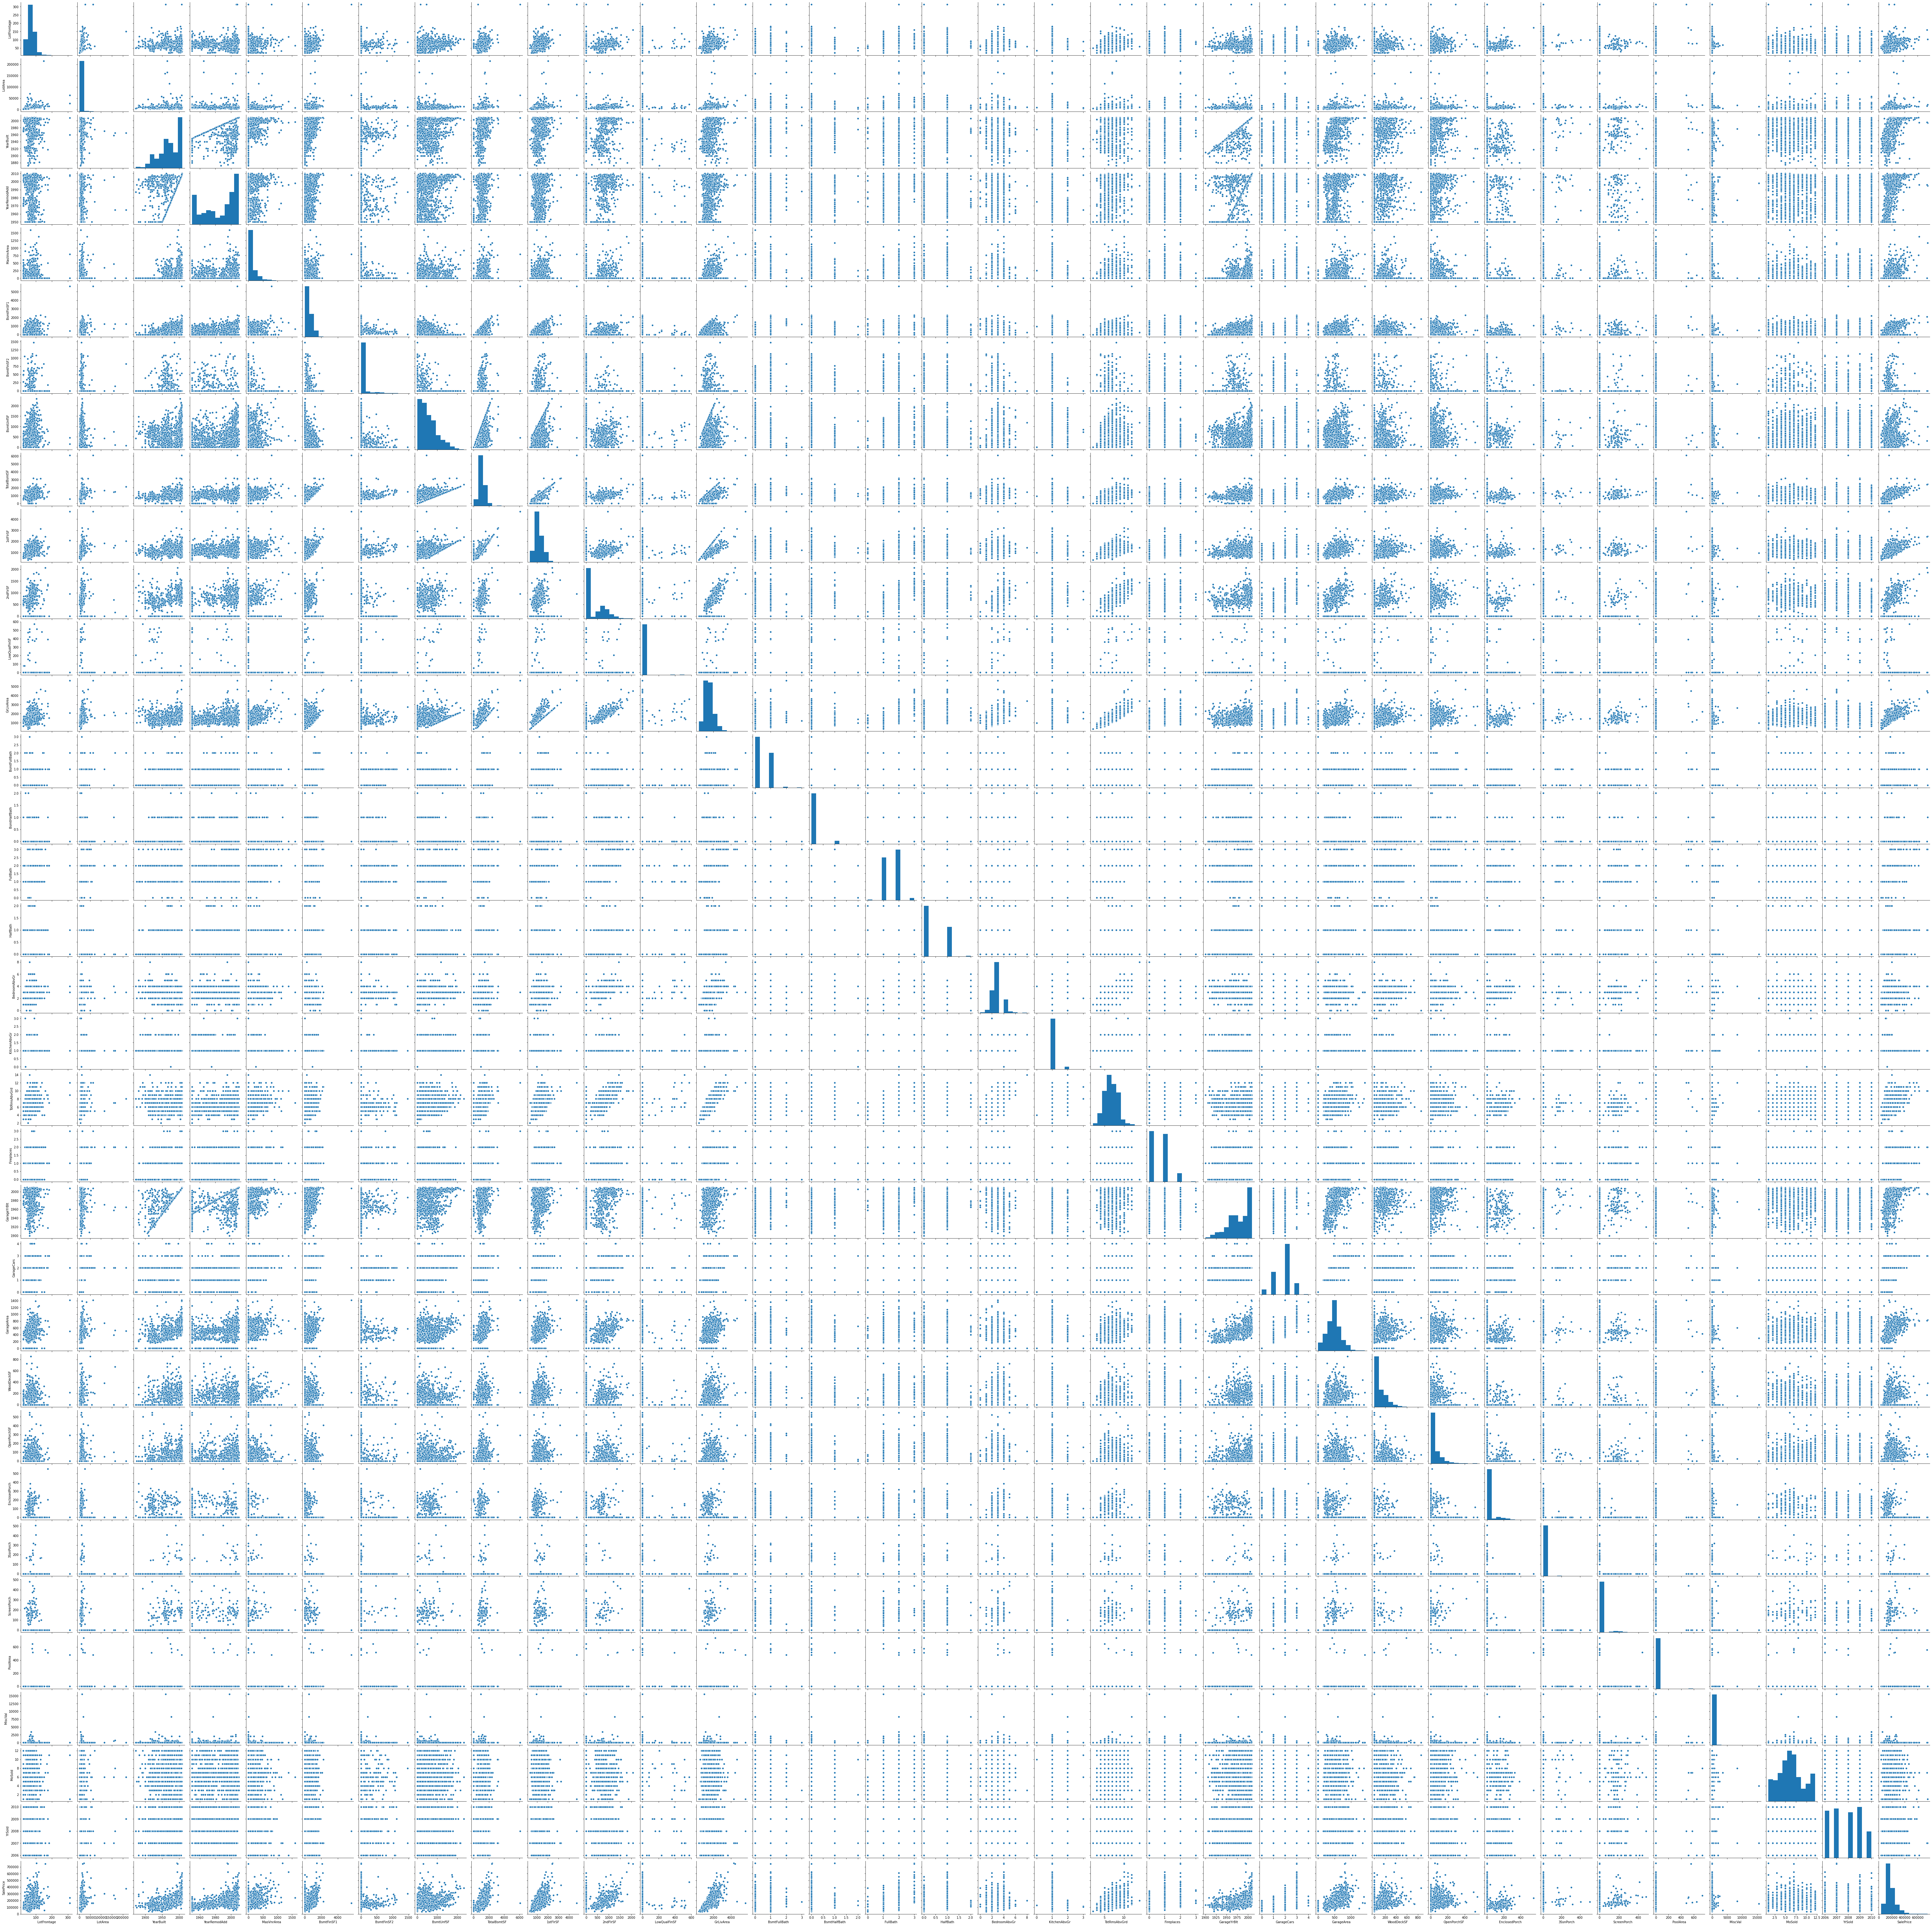

In [12]:
plt.figure(figsize=(20,10))
sns.pairplot(df_num_vars)
plt.show() 

In [13]:
#Correlation matrix
cor = df_num_vars.corr()
pd.options.display.max_columns = 34
cor 

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
LotFrontage       1.000000  0.426095   0.123349      0.088866    0.193458   
LotArea           0.426095  1.000000   0.014228      0.013788    0.104160   
YearBuilt         0.123349  0.014228   1.000000      0.592855    0.315707   
YearRemodAdd      0.088866  0.013788   0.592855      1.000000    0.179618   
MasVnrArea        0.193458  0.104160   0.315707      0.179618    1.000000   
BsmtFinSF1        0.233633  0.214103   0.249503      0.128451    0.264736   
BsmtFinSF2        0.049900  0.111170  -0.049107     -0.067759   -0.072319   
BsmtUnfSF         0.132644 -0.002618   0.149040      0.181133    0.114442   
TotalBsmtSF       0.392075  0.260833   0.391452      0.291066    0.363936   
1stFlrSF          0.457181  0.299475   0.281986      0.240379    0.344501   
2ndFlrSF          0.080177  0.050986   0.010308      0.140024    0.174561   
LowQualFinSF      0.038469  0.004779  -0.183784     -0.062419   -0.069071   
GrLivArea         0.402797  0.263116   0.199010      0.287389    0.390857   
BsmtFullBath      0.100949  0.158155   0.187599      0.119470    0.085310   
BsmtHalfBath     -0.007234  0.048046  -0.038162     -0.012337    0.026673   
FullBath          0.198769  0.126031   0.468271      0.439046    0.276833   
HalfBath          0.053532  0.014259   0.242656      0.183331    0.201444   
BedroomAbvGr      0.263170  0.119690  -0.070651     -0.040581    0.102821   
KitchenAbvGr     -0.006069 -0.017784  -0.174800     -0.149598   -0.037610   
TotRmsAbvGrd      0.352096  0.190015   0.095589      0.191740    0.280682   
Fireplaces        0.266639  0.271364   0.147716      0.112581    0.249070   
GarageYrBlt       0.070250 -0.024947   0.825667      0.642277    0.252691   
GarageCars        0.285691  0.154871   0.537850      0.420622    0.364204   
GarageArea        0.344997  0.180403   0.478954      0.371600    0.373066   
WoodDeckSF        0.088521  0.171698   0.224880      0.205726    0.159718   
OpenPorchSF       0.151972  0.084774   0.188686      0.226298    0.125703   
EnclosedPorch     0.010700 -0.018340  -0.387268     -0.193919   -0.110204   
3SsnPorch         0.070029  0.020423   0.031355      0.045286    0.018796   
ScreenPorch       0.041383  0.043160  -0.050364     -0.038740    0.061466   
PoolArea          0.206167  0.077672   0.004950      0.005829    0.011723   
MiscVal           0.003368  0.038068  -0.034383     -0.010286   -0.029815   
MoSold            0.011200  0.001205   0.012398      0.021490   -0.005965   
YrSold            0.007450 -0.014261  -0.013618      0.035743   -0.008201   
SalePrice         0.351799  0.263843   0.522897      0.507101    0.477493   

               BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
LotFrontage      0.233633    0.049900   0.132644     0.392075  0.457181   
LotArea          0.214103    0.111170  -0.002618     0.260833  0.299475   
YearBuilt        0.249503   -0.049107   0.149040     0.391452  0.281986   
YearRemodAdd     0.128451   -0.067759   0.181133     0.291066  0.240379   
MasVnrArea       0.264736   -0.072319   0.114442     0.363936  0.344501   
BsmtFinSF1       1.000000   -0.050117  -0.495251     0.522396  0.445863   
BsmtFinSF2      -0.050117    1.000000  -0.209294     0.104810  0.097117   
BsmtUnfSF       -0.495251   -0.209294   1.000000     0.415360  0.317987   
TotalBsmtSF      0.522396    0.104810   0.415360     1.000000  0.819530   
1stFlrSF         0.445863    0.097117   0.317987     0.819530  1.000000   
2ndFlrSF        -0.137079   -0.099260   0.004469    -0.174512 -0.202646   
LowQualFinSF    -0.064503    0.014807   0.028167    -0.033245 -0.014241   
GrLivArea        0.208171   -0.009640   0.240257     0.454868  0.566024   
BsmtFullBath     0.649212    0.158678  -0.422900     0.307351  0.244671   
BsmtHalfBath     0.067418    0.070948  -0.095804    -0.000315  0.001956   
FullBath         0.058543   -0.076444   0.288886     0.323722  0.380637   
HalfBath         0.004262   -0.032148  -0.04

## 2. Data Cleaning

In [14]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [15]:
df.LotFrontage.isnull().sum() 

259

In [16]:
df.LotFrontage.describe() 

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

As the column contains outliers, let's impute the null values with the mode.

In [17]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mode()[0]) 

In [18]:
df.LotFrontage.isnull().sum() 

0

In [19]:
#Treating the outliers...
df.LotFrontage.describe([.25,.50,.75,.90,.95,.99])

count    1460.000000
mean       68.267123
std        22.356355
min        21.000000
25%        60.000000
50%        63.000000
75%        79.000000
90%        92.000000
95%       104.000000
99%       137.410000
max       313.000000
Name: LotFrontage, dtype: float64

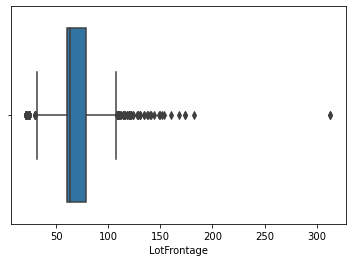

In [20]:
sns.boxplot(df['LotFrontage']) 

As we can see in the boxplot, outliers are definitelty present.

In [21]:
#Pick values in range(25,110)
df = df[(df.LotFrontage > 25) & (df.LotFrontage < 110)] 

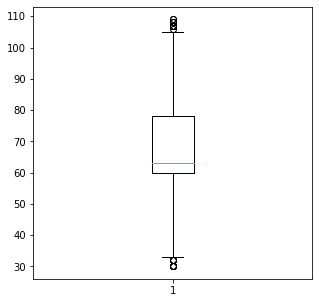

In [22]:
plt.figure(figsize=(5,5))
plt.boxplot(df['LotFrontage'])
plt.show() 

In [23]:
df.LotFrontage.describe() 

count    1365.000000
mean       67.044689
std        15.134400
min        30.000000
25%        60.000000
50%        63.000000
75%        78.000000
max       109.000000
Name: LotFrontage, dtype: float64

This situation is better than before,.

In [24]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1365 non-null   int64  
 1   MSSubClass     1365 non-null   int64  
 2   MSZoning       1365 non-null   object 
 3   LotFrontage    1365 non-null   float64
 4   LotArea        1365 non-null   int64  
 5   Street         1365 non-null   object 
 6   Alley          84 non-null     object 
 7   LotShape       1365 non-null   object 
 8   LandContour    1365 non-null   object 
 9   Utilities      1365 non-null   object 
 10  LotConfig      1365 non-null   object 
 11  LandSlope      1365 non-null   object 
 12  Neighborhood   1365 non-null   object 
 13  Condition1     1365 non-null   object 
 14  Condition2     1365 non-null   object 
 15  BldgType       1365 non-null   object 
 16  HouseStyle     1365 non-null   object 
 17  OverallQual    1365 non-null   int64  
 18  OverallC

In [25]:
#Change the data type of MSSubClass
df['MSSubClass'] = df['MSSubClass'].astype('object') 

Let's take a look at the categorical variable `Alley`.

In [26]:
df.Alley.isnull().sum() 

1281

In [27]:
df.Alley.value_counts() 

Grvl    48
Pave    36
Name: Alley, dtype: int64

As we can see that most of the records are `NA` in this column. Here, `NA` means there is no alley near the house. Ths is a very biased column as most of the records are `NA`. Hence, we will drop it.

In [28]:
df = df.drop('Alley', axis=1) 

In [29]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1365 non-null   int64  
 1   MSSubClass     1365 non-null   object 
 2   MSZoning       1365 non-null   object 
 3   LotFrontage    1365 non-null   float64
 4   LotArea        1365 non-null   int64  
 5   Street         1365 non-null   object 
 6   LotShape       1365 non-null   object 
 7   LandContour    1365 non-null   object 
 8   Utilities      1365 non-null   object 
 9   LotConfig      1365 non-null   object 
 10  LandSlope      1365 non-null   object 
 11  Neighborhood   1365 non-null   object 
 12  Condition1     1365 non-null   object 
 13  Condition2     1365 non-null   object 
 14  BldgType       1365 non-null   object 
 15  HouseStyle     1365 non-null   object 
 16  OverallQual    1365 non-null   int64  
 17  OverallCond    1365 non-null   int64  
 18  YearBuil

`PoolQC`, `Fence` and `MiscFeature` are similar cases and we will drop them as well.

In [30]:
df = df.drop(['PoolQC', 'Fence', 'MiscFeature'], axis=1) 

In [31]:
df.head() 

Id MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0   1         60       RL         65.0     8450   Pave      Reg         Lvl   
1   2         20       RL         80.0     9600   Pave      Reg         Lvl   
2   3         60       RL         68.0    11250   Pave      IR1         Lvl   
3   4         70       RL         60.0     9550   Pave      IR1         Lvl   
4   5         60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam   

  HouseStyle  OverallQual  ...  GarageCars  GarageArea  GarageQual GarageCond  \
0     2Story            7  ...           2         548          TA         TA   
1     1Story            6  ...           2         460          TA         TA   
2     2Story            7  ...           2         608          TA         TA   
3     2Story            7  ...           3         642          TA         TA   
4     2Story            8  ...           3         836          TA         TA   

  PavedDrive WoodDeckSF OpenPorchSF EnclosedPorch  3SsnPorch ScreenPorch  \
0          Y          0          61             0          0           0   
1          Y        298           0             0          0           0   
2          Y          0          42             0          0           0   
3          Y          0          35           272          0           0   
4          Y        192          84             0          0           0   

  PoolArea MiscVal MoSold YrSold SaleType SaleCondition  SalePrice  
0        0       0      2   2008       WD        Normal     208500  
1        0       0      5   2007       WD        Normal     181500  
2        0       0      9   2008       WD        Normal     223500  
3        0       0      2   2006       WD       Abnorml     140000  
4        0       0     12   2008       WD        Normal     250000  

[5 rows x 77 columns]

In [32]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1365 non-null   int64  
 1   MSSubClass     1365 non-null   object 
 2   MSZoning       1365 non-null   object 
 3   LotFrontage    1365 non-null   float64
 4   LotArea        1365 non-null   int64  
 5   Street         1365 non-null   object 
 6   LotShape       1365 non-null   object 
 7   LandContour    1365 non-null   object 
 8   Utilities      1365 non-null   object 
 9   LotConfig      1365 non-null   object 
 10  LandSlope      1365 non-null   object 
 11  Neighborhood   1365 non-null   object 
 12  Condition1     1365 non-null   object 
 13  Condition2     1365 non-null   object 
 14  BldgType       1365 non-null   object 
 15  HouseStyle     1365 non-null   object 
 16  OverallQual    1365 non-null   int64  
 17  OverallCond    1365 non-null   int64  
 18  YearBuil

`FireplaceQu` also has some `NA` values. Here, `NA` means the house doesn't have a fireplace. It has a significant amount of `NA` values but not enough to make it biased. So, we will impute the `NA` values with `No Fireplace`. 

In [33]:
df.FireplaceQu.value_counts() 

Gd    355
TA    291
Fa     32
Ex     22
Po     19
Name: FireplaceQu, dtype: int64

In [34]:
df['FireplaceQu'] = df['FireplaceQu'].fillna('No Fireplace') 

In [35]:
df.FireplaceQu.value_counts() 

No Fireplace    646
Gd              355
TA              291
Fa               32
Ex               22
Po               19
Name: FireplaceQu, dtype: int64

In [36]:
df.MasVnrType.value_counts() 

None       816
BrkFace    408
Stone      118
BrkCmn      15
Name: MasVnrType, dtype: int64

In [37]:
#Remove missing values of MasVnrType
df = df[~df.MasVnrType.isnull()] 

In [38]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1357 non-null   int64  
 1   MSSubClass     1357 non-null   object 
 2   MSZoning       1357 non-null   object 
 3   LotFrontage    1357 non-null   float64
 4   LotArea        1357 non-null   int64  
 5   Street         1357 non-null   object 
 6   LotShape       1357 non-null   object 
 7   LandContour    1357 non-null   object 
 8   Utilities      1357 non-null   object 
 9   LotConfig      1357 non-null   object 
 10  LandSlope      1357 non-null   object 
 11  Neighborhood   1357 non-null   object 
 12  Condition1     1357 non-null   object 
 13  Condition2     1357 non-null   object 
 14  BldgType       1357 non-null   object 
 15  HouseStyle     1357 non-null   object 
 16  OverallQual    1357 non-null   int64  
 17  OverallCond    1357 non-null   int64  
 18  YearBuil

Let's take a look at the variables pertaining to Basement.

In [39]:
df.BsmtQual.value_counts() 

TA    607
Gd    572
Ex    107
Fa     34
Name: BsmtQual, dtype: int64

In [40]:
df.BsmtCond.value_counts() 

TA    1215
Gd      61
Fa      42
Po       2
Name: BsmtCond, dtype: int64

In [41]:
df.BsmtExposure.value_counts() 

No    886
Av    202
Gd    121
Mn    110
Name: BsmtExposure, dtype: int64

In [42]:
df.BsmtFinType1.value_counts() 

Unf    400
GLQ    389
ALQ    201
BLQ    135
Rec    126
LwQ     69
Name: BsmtFinType1, dtype: int64

In [43]:
df.BsmtFinType2.value_counts() 

Unf    1164
Rec      51
LwQ      44
BLQ      32
ALQ      18
GLQ      10
Name: BsmtFinType2, dtype: int64

In [44]:
df['BsmtQual'] = df['BsmtQual'].fillna('No Bsmt') 
df['BsmtCond'] = df['BsmtCond'].fillna('No Bsmt') 
df['BsmtExposure'] = df['BsmtExposure'].fillna('No Bsmt') 
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('No Bsmt') 
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('No Bsmt') 

In [45]:
pd.options.display.max_rows = 100
df.isnull().sum() 

Id                0
MSSubClass        0
MSZoning          0
LotFrontage       0
LotArea           0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        0
MasVnrArea        0
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual          0
BsmtCond          0
BsmtExposure      0
BsmtFinType1      0
BsmtFinSF1        0
BsmtFinType2      0
BsmtFinSF2        0
BsmtUnfSF         0
TotalBsmtSF       0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0


In [46]:
#Electrical contains only 1 null value
df = df[~df.Electrical.isnull()] 

In [47]:
pd.options.display.max_rows = 100
df.isnull().sum() 

Id                0
MSSubClass        0
MSZoning          0
LotFrontage       0
LotArea           0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        0
MasVnrArea        0
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual          0
BsmtCond          0
BsmtExposure      0
BsmtFinType1      0
BsmtFinSF1        0
BsmtFinType2      0
BsmtFinSF2        0
BsmtUnfSF         0
TotalBsmtSF       0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        0
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0


In [48]:
df = df[~df.GarageYrBlt.isnull()] 

In [49]:
df.isnull().sum() 

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

In [50]:
df.shape

(1283, 77)

Now that we have gotten rid of the null values and are left with a decent number of records, we can move on to data preparation.

### Data Preparation

We will derive a variable which will define age of the house as it will be really good predictor for the price of a house.

- Age is defined as (current year - the year it was built)

In [51]:
import datetime as dt
date = dt.datetime.now() 

In [52]:
df['Age'] = df.YearBuilt.apply(lambda x: (date.year - x)) 

In [53]:
df = df.drop('YearBuilt', axis=1) 

In [54]:
df[['OverallQual', 'OverallCond']] = df[['OverallQual', 'OverallCond']].astype('object') 

In [55]:
df.head() 

Id MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0   1         60       RL         65.0     8450   Pave      Reg         Lvl   
1   2         20       RL         80.0     9600   Pave      Reg         Lvl   
2   3         60       RL         68.0    11250   Pave      IR1         Lvl   
3   4         70       RL         60.0     9550   Pave      IR1         Lvl   
4   5         60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
2    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
3    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
4    AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam   

  HouseStyle OverallQual  ... GarageArea  GarageQual GarageCond PavedDrive  \
0     2Story           7  ...        548          TA         TA          Y   
1     1Story           6  ...        460          TA         TA          Y   
2     2Story           7  ...        608          TA         TA          Y   
3     2Story           7  ...        642          TA         TA          Y   
4     2Story           8  ...        836          TA         TA          Y   

  WoodDeckSF OpenPorchSF EnclosedPorch  3SsnPorch ScreenPorch PoolArea  \
0          0          61             0          0           0        0   
1        298           0             0          0           0        0   
2          0          42             0          0           0        0   
3          0          35           272          0           0        0   
4        192          84             0          0           0        0   

  MiscVal MoSold YrSold SaleType SaleCondition  SalePrice  Age  
0       0      2   2008       WD        Normal     208500   17  
1       0      5   2007       WD        Normal     181500   44  
2       0      9   2008       WD        Normal     223500   19  
3       0      2   2006       WD       Abnorml     140000  105  
4       0     12   2008       WD        Normal     250000   20  

[5 rows x 77 columns]

In [56]:
for column in df.columns:
    print(df[column].value_counts()) 

1460    1
373     1
487     1
488     1
489     1
       ..
979     1
980     1
981     1
982     1
1       1
Name: Id, Length: 1283, dtype: int64
20     491
60     282
50     128
120     86
80      55
70      54
30      50
90      39
160     28
190     21
85      20
75      13
45       9
40       4
180      3
Name: MSSubClass, dtype: int64
RL         1042
RM          166
FV           56
RH           12
C (all)       7
Name: MSZoning, dtype: int64
60.0     380
80.0      68
70.0      65
75.0      51
50.0      50
65.0      42
85.0      39
78.0      25
90.0      22
68.0      19
64.0      19
79.0      17
73.0      17
72.0      16
100.0     16
74.0      15
66.0      15
63.0      14
52.0      13
59.0      13
51.0      13
71.0      12
82.0      12
57.0      12
43.0      12
69.0      11
76.0      11
55.0      11
86.0      10
40.0      10
53.0      10
34.0      10
88.0      10
84.0       9
44.0       9
92.0       8
61.0       8
98.0       8
62.0       8
67.0       8
93.0       8
96.0       8
77

Name: Age, Length: 108, dtype: int64


A few variables are highly baised, as clearly shown by their value counts. Let's take a threshold of 90% and remove those variables.

In [57]:
#Dropping variables that are highly biased
biased_vars = ['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'Heating', 'CentralAir', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
df = df.drop(biased_vars, axis=1) 

In [58]:
df.head() 

Id MSSubClass MSZoning  LotFrontage  LotArea LotShape LotConfig  \
0   1         60       RL         65.0     8450      Reg    Inside   
1   2         20       RL         80.0     9600      Reg       FR2   
2   3         60       RL         68.0    11250      IR1    Inside   
3   4         70       RL         60.0     9550      IR1    Corner   
4   5         60       RL         84.0    14260      IR1       FR2   

  Neighborhood Condition1 BldgType HouseStyle OverallQual OverallCond  \
0      CollgCr       Norm     1Fam     2Story           7           5   
1      Veenker      Feedr     1Fam     1Story           6           8   
2      CollgCr       Norm     1Fam     2Story           7           5   
3      Crawfor       Norm     1Fam     2Story           7           5   
4      NoRidge       Norm     1Fam     2Story           8           5   

   YearRemodAdd RoofStyle Exterior1st Exterior2nd  ... TotRmsAbvGrd  \
0          2003     Gable     VinylSd     VinylSd  ...            8   
1          1976     Gable     MetalSd     MetalSd  ...            6   
2          2002     Gable     VinylSd     VinylSd  ...            6   
3          1970     Gable     Wd Sdng     Wd Shng  ...            7   
4          2000     Gable     VinylSd     VinylSd  ...            9   

   Fireplaces   FireplaceQu GarageType GarageYrBlt GarageFinish GarageCars  \
0           0  No Fireplace     Attchd      2003.0          RFn          2   
1           1            TA     Attchd      1976.0          RFn          2   
2           1            TA     Attchd      2001.0          RFn          2   
3           1            Gd     Detchd      1998.0          Unf          3   
4           1            TA     Attchd      2000.0          RFn          3   

  GarageArea  WoodDeckSF OpenPorchSF  EnclosedPorch  MoSold  YrSold SaleType  \
0        548           0          61              0       2    2008       WD   
1        460         298           0              0       5    2007       WD   
2        608           0          42              0       9    2008       WD   
3        642           0          35            272       2    2006       WD   
4        836         192          84              0      12    2008       WD   

  SaleCondition  SalePrice  Age  
0        Normal     208500   17  
1        Normal     181500   44  
2        Normal     223500   19  
3       Abnorml     140000  105  
4        Normal     250000   20  

[5 rows x 57 columns]

In [59]:
df.shape

(1283, 57)

In [60]:
df_num_vars = df.select_dtypes(include=['float64', 'int64'])
df_num_vars = df_num_vars.drop('Id', axis=1)
df_num_vars.head() 

LotFrontage  LotArea  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
0         65.0     8450          2003       196.0         706           0   
1         80.0     9600          1976         0.0         978           0   
2         68.0    11250          2002       162.0         486           0   
3         60.0     9550          1970         0.0         216           0   
4         84.0    14260          2000       350.0         655           0   

   BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  \
0        150          856       856       854       1710             1   
1        284         1262      1262         0       1262             0   
2        434          920       920       866       1786             1   
3        540          756       961       756       1717             1   
4        490         1145      1145      1053       2198             1   

   FullBath  HalfBath  BedroomAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  \
0         2         1             3             8           0       2003.0   
1         2         0             3             6           1       1976.0   
2         2         1             3             6           1       2001.0   
3         1         0             3             7           1       1998.0   
4         2         1             4             9           1       2000.0   

   GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  MoSold  \
0           2         548           0           61              0       2   
1           2         460         298            0              0       5   
2           2         608           0           42              0       9   
3           3         642           0           35            272       2   
4           3         836         192           84              0      12   

   YrSold  SalePrice  Age  
0    2008     208500   17  
1    2007     181500   44  
2    2008     223500   19  
3    2006     140000  105  
4    2008     250000   20

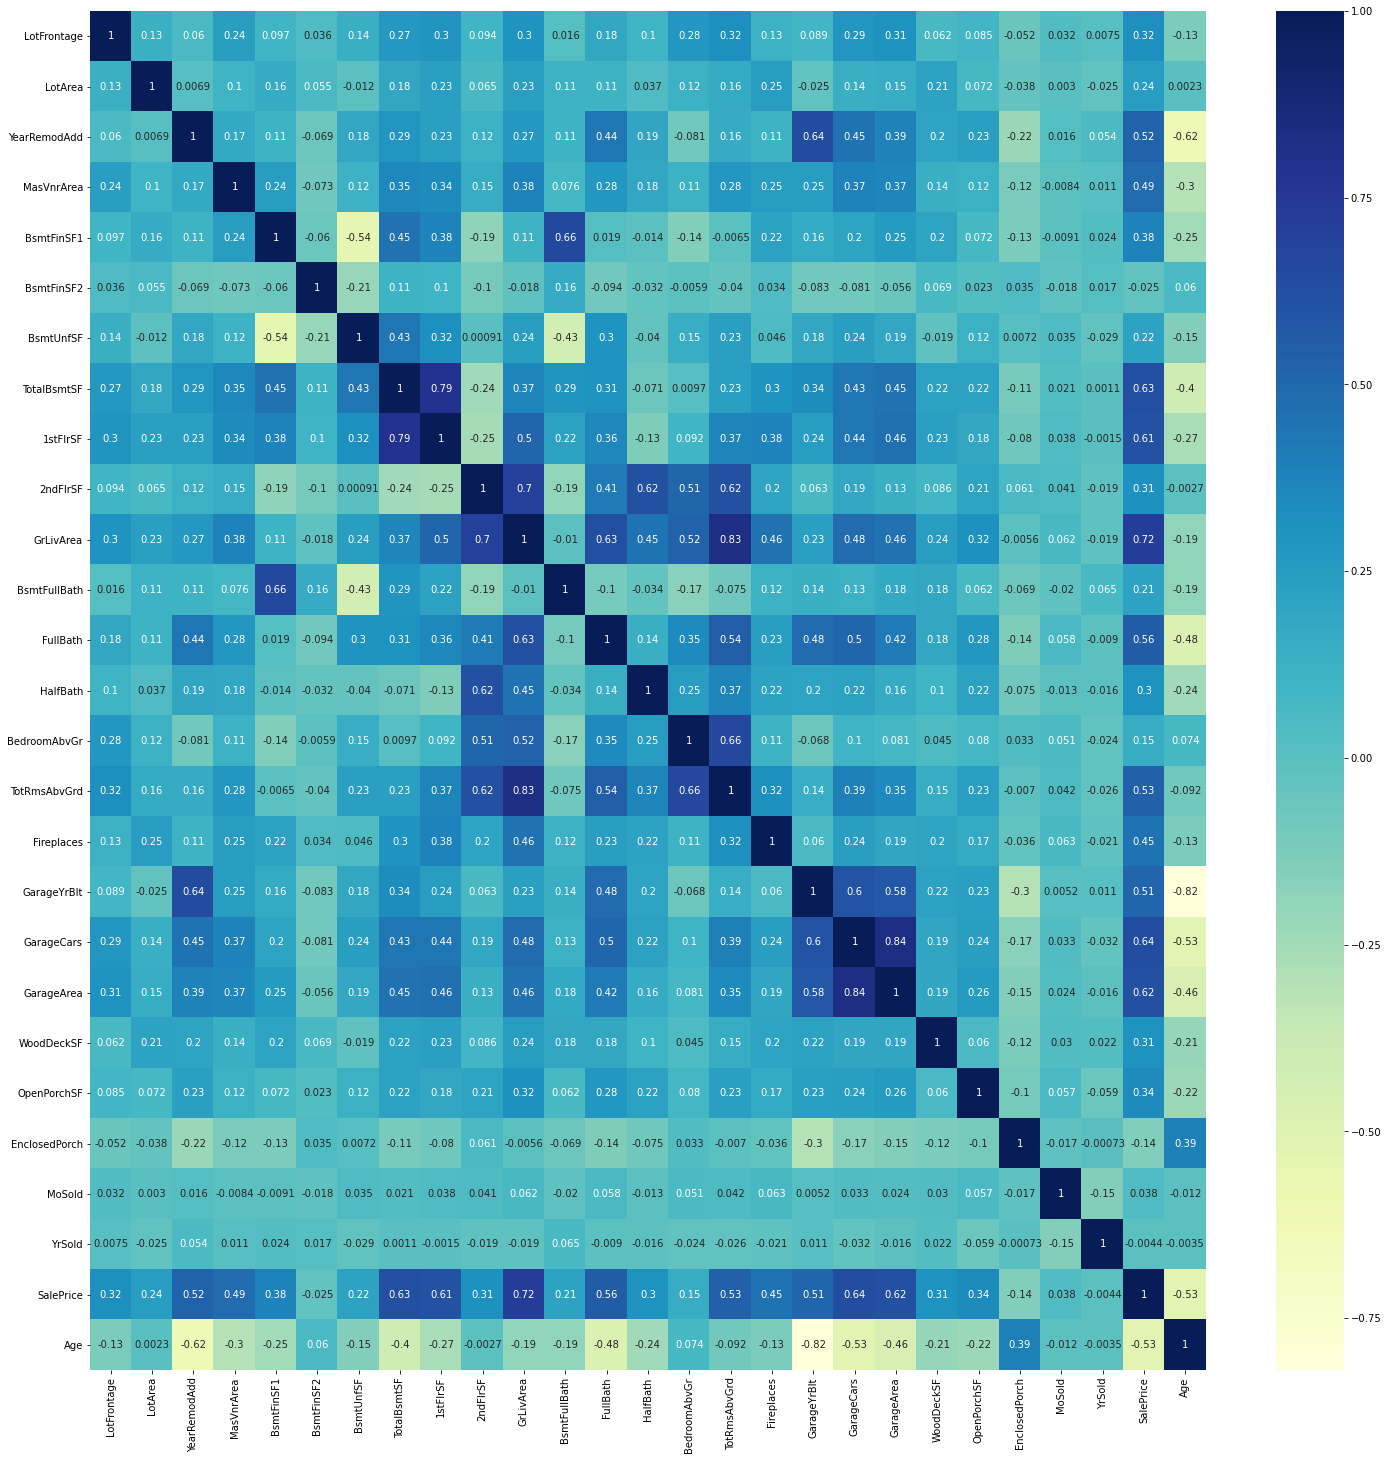

In [64]:
#plot the correlations on a heatmap
plt.figure(figsize=(25,25))
sns.heatmap(df_num_vars.corr(), cmap='YlGnBu', annot=True)
plt.show() 

`TotRmsAbvGrd` is highly correlated with `GrLivArea` and `GarageYrBlt` is highly correlated with `Age`.

In [65]:
#Drop TotRmsAbvGrd and GarageYrBlt
df = df.drop(['TotRmsAbvGrd', 'GarageYrBlt'], axis=1) 

Now, we move on to the categorical variables.

In [67]:
df_categorical = df.select_dtypes(include=['object'])
df_categorical.head() 

MSSubClass MSZoning LotShape LotConfig Neighborhood Condition1 BldgType  \
0         60       RL      Reg    Inside      CollgCr       Norm     1Fam   
1         20       RL      Reg       FR2      Veenker      Feedr     1Fam   
2         60       RL      IR1    Inside      CollgCr       Norm     1Fam   
3         70       RL      IR1    Corner      Crawfor       Norm     1Fam   
4         60       RL      IR1       FR2      NoRidge       Norm     1Fam   

  HouseStyle OverallQual OverallCond RoofStyle Exterior1st Exterior2nd  \
0     2Story           7           5     Gable     VinylSd     VinylSd   
1     1Story           6           8     Gable     MetalSd     MetalSd   
2     2Story           7           5     Gable     VinylSd     VinylSd   
3     2Story           7           5     Gable     Wd Sdng     Wd Shng   
4     2Story           8           5     Gable     VinylSd     VinylSd   

  MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtExposure  \
0    BrkFace        Gd        TA      PConc       Gd           No   
1       None        TA        TA     CBlock       Gd           Gd   
2    BrkFace        Gd        TA      PConc       Gd           Mn   
3       None        TA        TA     BrkTil       TA           No   
4    BrkFace        Gd        TA      PConc       Gd           Av   

  BsmtFinType1 BsmtFinType2 HeatingQC Electrical KitchenQual   FireplaceQu  \
0          GLQ          Unf        Ex      SBrkr          Gd  No Fireplace   
1          ALQ          Unf        Ex      SBrkr          TA            TA   
2          GLQ          Unf        Ex      SBrkr          Gd            TA   
3          ALQ          Unf        Gd      SBrkr          Gd            Gd   
4          GLQ          Unf        Ex      SBrkr          Gd            TA   

  GarageType GarageFinish SaleType SaleCondition  
0     Attchd          RFn       WD        Normal  
1     Attchd          RFn       WD        Normal  
2     Attchd          RFn       WD        Normal  
3     Detchd          Unf       WD       Abnorml  
4     Attchd          RFn       WD        Normal

### Dummy Variables

Now, we will get the dummy variables for the categorical variables.

In [68]:
#Getting columns of categorical variables
categorical_cols = df_categorical.columns
categorical_cols

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition'],
      dtype='object')

In [69]:
#Getting dummy vars for these columns
df_dummy = pd.get_dummies(df_categorical[categorical_cols], drop_first=True)
df_dummy.head() 

MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  \
0              0              0              0              0              1   
1              0              0              0              0              0   
2              0              0              0              0              1   
3              0              0              0              0              0   
4              0              0              0              0              1   

   MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              1              0              0              0              0   
4              0              0              0              0              0   

   MSSubClass_120  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   MSZoning_FV  MSZoning_RH  MSZoning_RL  ...  GarageType_CarPort  \
0            0            0            1  ...                   0   
1            0            0            1  ...                   0   
2            0            0            1  ...                   0   
3            0            0            1  ...                   0   
4            0            0            1  ...                   0   

   GarageType_Detchd  GarageFinish_RFn  GarageFinish_Unf  SaleType_CWD  \
0                  0                 1                 0             0   
1                  0                 1                 0             0   
2                  0                 1                 0             0   
3                  1                 0                 1             0   
4                  0                 1                 0             0   

   SaleType_Con  SaleType_ConLD  SaleType_ConLI  SaleType_ConLw  SaleType_New  \
0             0               0               0               0             0   
1             0               0               0               0             0   
2             0               0               0               0             0   
3             0               0               0               0             0   
4             0               0               0               0             0   

   SaleType_Oth  SaleType_WD  SaleCondition_AdjLand  SaleCondition_Alloca  \
0             0            1                      0                     0   
1             0            1                      0                     0   
2             0            1                      0                     0   
3             0            1                      0                     0   
4             0            1                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 184 columns]

In [70]:
#Joining df with df_dummy and dropping categorical columns
df = pd.concat([df, df_dummy], axis=1)
df = df.drop(categorical_cols, axis=1)
df.head() 

Id  LotFrontage  LotArea  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
0   1         65.0     8450          2003       196.0         706           0   
1   2         80.0     9600          1976         0.0         978           0   
2   3         68.0    11250          2002       162.0         486           0   
3   4         60.0     9550          1970         0.0         216           0   
4   5         84.0    14260          2000       350.0         655           0   

   BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  \
0        150          856       856       854       1710             1   
1        284         1262      1262         0       1262             0   
2        434          920       920       866       1786             1   
3        540          756       961       756       1717             1   
4        490         1145      1145      1053       2198             1   

   FullBath  HalfBath  BedroomAbvGr  Fireplaces  ...  GarageType_CarPort  \
0         2         1             3           0  ...                   0   
1         2         0             3           1  ...                   0   
2         2         1             3           1  ...                   0   
3         1         0             3           1  ...                   0   
4         2         1             4           1  ...                   0   

   GarageType_Detchd  GarageFinish_RFn  GarageFinish_Unf  SaleType_CWD  \
0                  0                 1                 0             0   
1                  0                 1                 0             0   
2                  0                 1                 0             0   
3                  1                 0                 1             0   
4                  0                 1                 0             0   

   SaleType_Con  SaleType_ConLD  SaleType_ConLI  SaleType_ConLw  SaleType_New  \
0             0               0               0               0             0   
1             0               0               0               0             0   
2             0               0               0               0             0   
3             0               0               0               0             0   
4             0               0               0               0             0   

   SaleType_Oth  SaleType_WD  SaleCondition_AdjLand  SaleCondition_Alloca  \
0             0            1                      0                     0   
1             0            1                      0                     0   
2             0            1                      0                     0   
3             0            1                      0                     0   
4             0            1                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 210 columns]

`Id` is an insignificant variable.

In [71]:
#Dropping Id
df = df.drop('Id', axis=1)
df.head() 

LotFrontage  LotArea  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
0         65.0     8450          2003       196.0         706           0   
1         80.0     9600          1976         0.0         978           0   
2         68.0    11250          2002       162.0         486           0   
3         60.0     9550          1970         0.0         216           0   
4         84.0    14260          2000       350.0         655           0   

   BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  \
0        150          856       856       854       1710             1   
1        284         1262      1262         0       1262             0   
2        434          920       920       866       1786             1   
3        540          756       961       756       1717             1   
4        490         1145      1145      1053       2198             1   

   FullBath  HalfBath  BedroomAbvGr  Fireplaces  GarageCars  ...  \
0         2         1             3           0           2  ...   
1         2         0             3           1           2  ...   
2         2         1             3           1           2  ...   
3         1         0             3           1           3  ...   
4         2         1             4           1           3  ...   

   GarageType_CarPort  GarageType_Detchd  GarageFinish_RFn  GarageFinish_Unf  \
0                   0                  0                 1                 0   
1                   0                  0                 1                 0   
2                   0                  0                 1                 0   
3                   0                  1                 0                 1   
4                   0                  0                 1                 0   

   SaleType_CWD  SaleType_Con  SaleType_ConLD  SaleType_ConLI  SaleType_ConLw  \
0             0             0               0               0               0   
1             0             0               0               0               0   
2             0             0               0               0               0   
3             0             0               0               0               0   
4             0             0               0               0               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_AdjLand  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      0   
4             0             0            1                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 209 columns]

In [72]:
df.shape

(1283, 209)

Check the distribution of the target variable i.e. `SalePrice`.

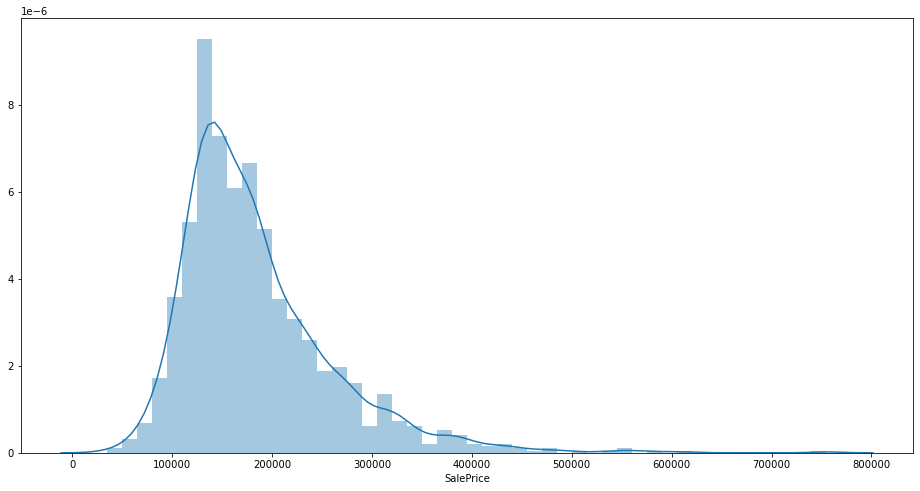

In [73]:
plt.figure(figsize=(16,8))
sns.distplot(df.SalePrice)
plt.show() 

## Split the Dataset

In [74]:
df_train, df_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=42) 

#### Scaling df_train and df_test

In [76]:
num_vars = df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.transform(df_test[num_vars]) 

#### Splitting df_train and df_test into X and y 

In [77]:
y_train = df_train.pop('SalePrice')
X_train = df_train

y_test = df_test.pop('SalePrice')
X_test = df_test

### Model Building and Evaluation

In [78]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 50)
rfe.fit(X_train, y_train) 

RFE(estimator=LinearRegression(), n_features_to_select=50)

In [79]:
df_rfe = pd.DataFrame(list(zip(X_train.columns, rfe.support_, rfe.ranking_)))
df_rfe.columns = ['Column_N', 'Status', 'Ranking'] 

In [80]:
rfe_selected_cols = list(df_rfe[df_rfe.Status==True].Column_N) 

In [81]:
X_train = X_train[rfe_selected_cols]
X_test = X_test[rfe_selected_cols] 

### Regularization

- We can use regularization to tune the hyperparameters.

Let's take a look at __Ridge Regression__.

In [82]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

#Cross Validation
folds = 5 
model_cv = GridSearchCV(estimator = ridge,
                       param_grid = params,
                       scoring = 'neg_mean_absolute_error',
                       cv = folds,
                       return_train_score = True,
                       verbose = 1)
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.5s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [83]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head() 

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.063730      0.119482         0.002206        0.001324      0.0001   
1       0.003125      0.006250         0.003125        0.006250       0.001   
2       0.003125      0.006250         0.003125        0.006250        0.01   
3       0.003125      0.006250         0.003125        0.006250        0.05   
4       0.006250      0.007654         0.000000        0.000000         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}          -0.234944          -0.228843          -0.239299   
1   {'alpha': 0.001}          -0.234938          -0.228833          -0.239302   
2    {'alpha': 0.01}          -0.234881          -0.228734          -0.239342   
3    {'alpha': 0.05}          -0.234644          -0.228317          -0.239518   
4     {'alpha': 0.1}          -0.234386          -0.227846          -0.239737   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0          -0.224083          -0.212065        -0.227847        0.009442   
1          -0.224081          -0.212047        -0.227840        0.009448   
2          -0.224064          -0.211863        -0.227777        0.009510   
3          -0.223979          -0.211135        -0.227519        0.009761   
4          -0.223863          -0.210436        -0.227254        0.010014   

   rank_test_score  split0_train_score  split1_train_score  \
0               14           -0.206952           -0.210967   
1               13           -0.206951           -0.210964   
2               12           -0.206944           -0.210935   
3               11           -0.206915           -0.210811   
4               10           -0.206882           -0.210667   

   split2_train_score  split3_train_score  split4_train_score  \
0           -0.207519           -0.213057           -0.211699   
1           -0.207517           -0.213058           -0.211700   
2           -0.207494           -0.213068           -0.211708   
3           -0.207395           -0.213121           -0.211743   
4           -0.207350           -0.213239           -0.211814   

   mean_train_score  std_train_score  
0         -0.210039         0.002392  
1         -0.210038         0.002393  
2         -0.210030         0.002401  
3         -0.209997         0.002439  
4         -0.209990         0.002489

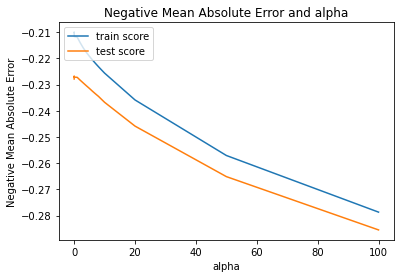

In [84]:
#Plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show() 

From Ridge regression also we can see that best results at alpha = __0.001__.

Now, let's take a look at __Lasso Regression__. 

In [85]:
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print("Train R2: {0}".format(r2_score(y_true=y_train,y_pred=y_train_pred)))

y_test_pred  = lm.predict(X_test)
print("Test R2: {0}".format(r2_score(y_true=y_test,y_pred=y_test_pred))) 

Train R2: 0.9100088349441704
Test R2: 0.8871653768929427


Both Train and Test R2 score look good and indicate signs of a good model as well as a good alpha value.

In [86]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = df_train.columns
col.insert(0,'Constant')
list(zip(col,model_parameter)) 

[('LotFrontage', 0.23),
 ('LotArea', 0.199),
 ('YearRemodAdd', 0.267),
 ('MasVnrArea', 0.332),
 ('BsmtFinSF1', -0.231),
 ('BsmtFinSF2', 0.186),
 ('BsmtUnfSF', 0.126),
 ('TotalBsmtSF', 0.0),
 ('1stFlrSF', -0.363),
 ('2ndFlrSF', -0.154),
 ('GrLivArea', 0.103),
 ('BsmtFullBath', 0.162),
 ('FullBath', 0.404),
 ('HalfBath', -0.073),
 ('BedroomAbvGr', 0.312),
 ('Fireplaces', 0.48),
 ('GarageCars', -0.169),
 ('GarageArea', -0.013),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', -0.099),
 ('EnclosedPorch', -0.102),
 ('MoSold', 0.139),
 ('YrSold', 0.41),
 ('Age', 0.974),
 ('MSSubClass_30', 0.908),
 ('MSSubClass_40', -0.025),
 ('MSSubClass_45', 0.076),
 ('MSSubClass_50', 0.181),
 ('MSSubClass_60', 0.338),
 ('MSSubClass_70', 0.29),
 ('MSSubClass_75', 0.467),
 ('MSSubClass_80', 0.183),
 ('MSSubClass_85', -0.0),
 ('MSSubClass_90', -0.0),
 ('MSSubClass_120', -0.0),
 ('MSSubClass_160', -0.0),
 ('MSSubClass_180', 0.166),
 ('MSSubClass_190', -0.227),
 ('MSZoning_FV', -0.254),
 ('MSZoning_RH', -0.189),
 ('MSZon

Now, let's use `GridSearchCV` with 10 folds.

In [87]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 42)
hyper_param = {'alpha': [0.001, 0.01, 0.1,1.0, 5.0, 10.0, 20.0]}
model = Lasso() 
model_cv = GridSearchCV(estimator = model,
                       param_grid = hyper_param,
                       scoring = 'r2',
                       cv = folds,
                       verbose = 1,
                       return_train_score = True)
model_cv.fit(X_train, y_train) 

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.7s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [88]:
cv_res_lasso = pd.DataFrame(model_cv.cv_results_)
cv_res_lasso['param_alpha'] = cv_res_lasso['param_alpha'].astype('float32')
cv_res_lasso.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_alpha  \
0       0.010093      0.001868         0.003999        0.000632        0.001   
1       0.005101      0.002500         0.003962        0.004066        0.010   
2       0.001562      0.004687         0.006249        0.007654        0.100   
3       0.004687      0.007160         0.001563        0.004688        1.000   
4       0.005446      0.006144         0.004224        0.005923        5.000   

             params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.001}           0.890598           0.916455           0.903098   
1   {'alpha': 0.01}           0.845259           0.866295           0.832024   
2    {'alpha': 0.1}           0.695877           0.682682           0.677161   
3    {'alpha': 1.0}          -0.028720          -0.009033          -0.001938   
4    {'alpha': 5.0}          -0.028720          -0.009033          -0.001938   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
0           0.916771           0.918533           0.898448           0.863897   
1           0.874999           0.868264           0.864749           0.855554   
2           0.720162           0.703868           0.750026           0.779759   
3          -0.019411          -0.005990          -0.007565          -0.065369   
4          -0.019411          -0.005990          -0.007565          -0.065369   

   split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
0           0.883787           0.872167           0.873884         0.893764   
1           0.832538           0.828540           0.827253         0.849548   
2           0.643928           0.685497           0.691606         0.703056   
3          -0.001022          -0.025646          -0.001301        -0.016600   
4          -0.001022          -0.025646          -0.001301        -0.016600   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.019053                1            0.911282            0.908897   
1        0.017604                2            0.862119            0.859488   
2        0.036682                3            0.697422            0.707323   
3        0.018863                4            0.000000            0.000000   
4        0.018863                4            0.000000            0.000000   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.910059            0.908927            0.908235   
1            0.860807            0.857567            0.857582   
2            0.708223            0.701670            0.706542   
3            0.000000            0.000000            0.000000   
4            0.000000            0.000000            0.000000   

   split5_train_score  split6_train_score  split7_train_score  \
0            0.909865            0.912886            0.912762   
1            0.861528            0.863678            0.860139   
2            0.703337            0.704354            0.713298   
3            0.000000            0.000000            0.000000   
4            0.000000            0.000000            0.000000   

   split8_train_score  split9_train_score  mean_train_score  std_train_score  
0            0.911665            0.912487          0.910706         0.001645  
1            0.863802            0.864170          0.861088         0.002303  
2            0.707941            0.709163          0.705927         0.004196  
3            0.000000            0.000000          0.000000         0.000000  
4            0.000000            0.000000          0.000000         0.000000

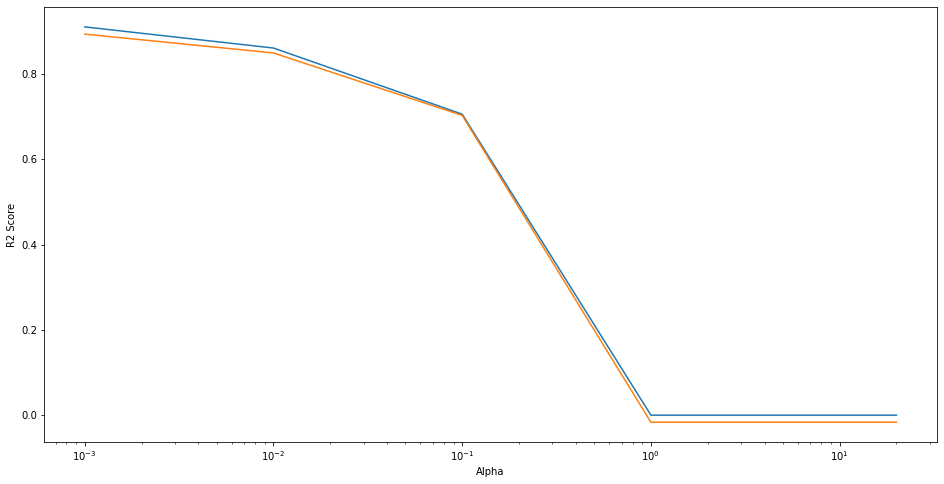

In [90]:
# Comparing R-Squared and alpha of Train and Test dataset
plt.figure(figsize=(16,8))
plt.plot(cv_res_lasso['param_alpha'],cv_res_lasso['mean_train_score'])
plt.plot(cv_res_lasso['param_alpha'],cv_res_lasso['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show() 

#### Best Value of alpha

In [91]:
model_cv.best_params_ 

{'alpha': 0.001}

In [92]:
lasso = Lasso(alpha = 0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true = y_train,y_pred = y_train_pred))
print(r2_score(y_true = y_test,y_pred = y_test_pred)) 

0.9100088349441704
0.8871653768929427


#### Top 10 Features

In [93]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = df_train.columns
cols.insert(0,'const')
lasso_coeff = pd.DataFrame(list(zip(cols,model_param)))
lasso_coeff.columns = ['Feature','Coeff'] 

In [94]:
lasso_coeff.sort_values(by='Coeff',ascending=False).head(10) 

Feature     Coeff
23            Age  0.974339
24  MSSubClass_30  0.907721
15     Fireplaces  0.479589
30  MSSubClass_75  0.467358
22         YrSold  0.409587
12       FullBath  0.404425
41    MSZoning_RM  0.342757
28  MSSubClass_60  0.337884
3      MasVnrArea  0.332100
14   BedroomAbvGr  0.311517

In [95]:
print(lasso_coeff.sort_values(by='Coeff',ascending=False).head(10)) 

          Feature     Coeff
23            Age  0.974339
24  MSSubClass_30  0.907721
15     Fireplaces  0.479589
30  MSSubClass_75  0.467358
22         YrSold  0.409587
12       FullBath  0.404425
41    MSZoning_RM  0.342757
28  MSSubClass_60  0.337884
3      MasVnrArea  0.332100
14   BedroomAbvGr  0.311517
